In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
import gc

In [122]:
#FILE
model_folder='eda/models/sample_run/'
comment='_valid_hr_is_test_hr'
model_file='model'+comment
model_save=model_folder+model_file
metrics_file='eda/metrics.csv'

In [123]:
metrics = 'auc'

In [124]:
train_feature_file='eda/features/train/all_features.csv'
# valid_feature_file='eda/features/train/all_features.csv'
valid_feature_file='eda/features/valid/all_features_valid_hr_is_test_hr.csv'

In [125]:
train_df=pd.read_csv(train_feature_file,parse_dates=['click_date'])
val_df=pd.read_csv(valid_feature_file,parse_dates=['click_date'])
train_df=train_df.drop(['ip','click_time', 'attributed_time','click_date'],axis=1)
val_df=val_df.drop(['ip','click_time', 'attributed_time','click_date'],axis=1)

print(train_df.info())
print(val_df.info())

print("train size: ", len(train_df))
print("valid size: ", len(val_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659630 entries, 0 to 659629
Data columns (total 15 columns):
app               659630 non-null int64
device            659630 non-null int64
os                659630 non-null int64
channel           659630 non-null int64
is_attributed     659630 non-null int64
hour              659630 non-null int64
day               659630 non-null int64
minute            659630 non-null int64
IN_TEST_HH        659630 non-null int64
IP_DAY_TEST_HH    659630 non-null int64
IP_DAY_HH         659630 non-null int64
IP_OS_HH          659630 non-null int64
IP_APP_HH         659630 non-null int64
IP_APP_OS_HH      659630 non-null int64
APP_DAY_HH        659630 non-null int64
dtypes: int64(15)
memory usage: 75.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150531 entries, 0 to 150530
Data columns (total 15 columns):
app               150531 non-null int64
device            150531 non-null int64
os                150531 non-null int64
channel      

In [126]:
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':metrics,
        'learning_rate': 0.1,
        'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'nthread': 4,
        'verbose': 0,
        'scale_pos_weight':99.7, # because training data is extremely unbalanced 
        'metric':metrics
}
target = 'is_attributed'
predictors = ['app', 'device', 'os', 'channel', 'hour',
       'day', 'IN_TEST_HH', 'IP_DAY_TEST_HH', 'IP_DAY_HH', 'IP_OS_HH',
       'IP_APP_HH', 'IP_APP_OS_HH', 'APP_DAY_HH']
categorical = ['app', 'device', 'os', 'channel', 'hour','day']


In [127]:
VALIDATE = True
MAX_ROUNDS = 500
EARLY_STOP = 50
OPT_ROUNDS = 500
print("Training...")

num_boost_round=MAX_ROUNDS
early_stopping_rounds=EARLY_STOP

xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del train_df
gc.collect()
print('done...')

Training...


188

done...


In [128]:
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

186

In [129]:
evals_results = {}
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgtrain, xgvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

n_estimators = bst.best_iteration
bst.save_model(model_save)
print("\nModel Report")
print("n_estimators : ", n_estimators)
print(metrics+":", evals_results['valid'][metrics][n_estimators-1])
del xgvalid

/Users/aronak/miniconda3/envs/ml_3_6/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/aronak/miniconda3/envs/ml_3_6/lib/python3.5/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.960914	valid's auc: 0.945332
[20]	train's auc: 0.967306	valid's auc: 0.948549
[30]	train's auc: 0.9724	valid's auc: 0.95091
[40]	train's auc: 0.975791	valid's auc: 0.951592
[50]	train's auc: 0.978581	valid's auc: 0.952719
[60]	train's auc: 0.980794	valid's auc: 0.952478
[70]	train's auc: 0.982528	valid's auc: 0.952318
[80]	train's auc: 0.983775	valid's auc: 0.951418
[90]	train's auc: 0.986026	valid's auc: 0.950903
Early stopping, best iteration is:
[46]	train's auc: 0.977335	valid's auc: 0.953036

Model Report
n_estimators :  46
auc: 0.9530360361858687


In [130]:
def get_feature_imp(bst):
    x=dict(zip(bst.feature_name(),bst.feature_importance()))
    import operator
    sorted_x = sorted(x.items(), key=operator.itemgetter(1),reverse=True)
    return sorted_x

In [131]:
import datetime
date_time=datetime.datetime.now()
train_acc=evals_results['train']['auc'][n_estimators-1]
valid_acc=evals_results['valid']['auc'][n_estimators-1]
bst_iter=n_estimators
feature_imp=get_feature_imp(bst)
comment='1M,andys features,specific hours'+comment

In [132]:
#prepare metrics and see
col_list=['date_time','train_acc','valid_acc','best_iter','cols','model_file','feature_imp','comment','lBSCore']
curr_data=pd.DataFrame([[date_time,train_acc,valid_acc,bst_iter,predictors,model_save,feature_imp,comment,'Unknown']], columns=col_list)
curr_data.head()

,date_time,train_acc,valid_acc,best_iter,cols,model_file,feature_imp,comment,lBSCore
0,2018-04-12 11:53:21.394388,0.977335,0.953036,46,"[app, device, os, channel, hour, day, IN_TEST_...",eda/models/sample_run/model_valid_hr_is_test_hr,"[(channel, 80), (app, 73), (os, 49), (IP_DAY_T...","1M,andys features,specific hours_valid_hr_is_t...",Unknown


In [133]:
# ADD to records
add_to_records=True
log=pd.read_csv(metrics_file)
log.head()
if(add_to_records):
    log.append(curr_data)
    log.to_csv(metrics_file,index=False)
    print('records updated')
gc.collect()
#resetCSV
# curr_data.to_csv(metrics_file,index=False)
# curr_data.head()

,date_time,train_acc,valid_acc,best_iter,cols,comment
0,2018-04-11 18:56:47.435974,0.997562,0.997562,496,"['app', 'device', 'os', 'channel', 'hour', 'da...","1M, andys features,specific hours"


,best_iter,cols,comment,date_time,feature_imp,lBSCore,model_file,train_acc,valid_acc
0,496,"['app', 'device', 'os', 'channel', 'hour', 'da...","1M, andys features,specific hours",2018-04-11 18:56:47.435974,NaN,NaN,NaN,0.997562,0.997562
0,46,"[app, device, os, channel, hour, day, IN_TEST_...","1M,andys features,specific hours_valid_hr_is_t...",2018-04-12 11:53:21.394388,"[(channel, 80), (app, 73), (os, 49), (IP_DAY_T...",Unknown,eda/models/sample_run/model_valid_hr_is_test_hr,0.977335,0.953036


records updated


67

Plot metrics during training...1


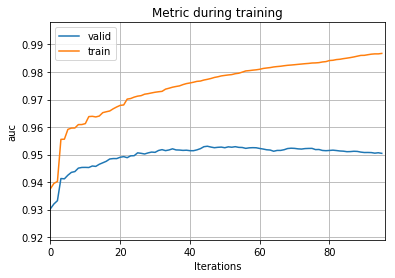

In [134]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plot_example.py.')

print('Plot metrics during training...1')
ax = lgb.plot_metric(evals_results)
plt.show()

Plot feature importances...


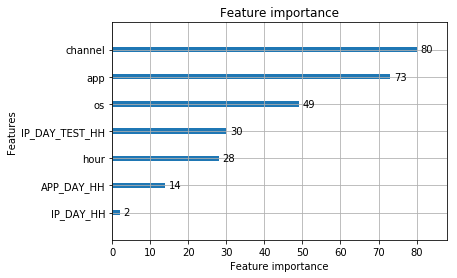

In [135]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plot_example.py.')

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=50)
plt.show()